In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from linearmodels.panel.data import PanelData
from linearmodels.panel import PanelOLS, PooledOLS, RandomEffects, compare
import matplotlib.pyplot as plt

In [2]:
def plot_result(result,start_from=1,period=20,file_name="result",title="Event Study Coefficients with Confidence Intervals"):
    summary_table=pd.DataFrame(result.summary.tables[1].data[start_from:start_from+period+1],columns=result.summary.tables[1].data[0])
    summary_table["Time"]=np.array(list(range(-5,period-5+1)))
    # make each column of summary_table numeric
    summary_table=summary_table.apply(pd.to_numeric, errors='ignore')
    plt.figure(figsize=(10, 6))  # Adjust figure size as needed

    # Plot coefficients as points
    plt.plot(summary_table['Time'], summary_table["Parameter"], 'o-', label='Coefficients', color='b')

    # Plot confidence intervals as error bars
    # plt.errorbar(summary_table['Time'], summary_table["Parameter"],
    #              yerr=[summary_table["Parameter"] - summary_table['Lower CI'],
    #                    summary_table['Upper CI'] - summary_table["Parameter"]],
    #              fmt='none', ecolor='orange', elinewidth=2, capsize=4, label='Confidence Intervals')

    plt.fill_between(summary_table['Time'], summary_table['Lower CI'], summary_table['Upper CI'], color='orange', alpha=0.3, label='Confidence Intervals')

    plt.xlabel('Time')
    plt.ylabel("Parameter")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.savefig("./plots/{}.png".format(file_name),dpi=300,bbox_inches="tight",transparent=False,facecolor="white")
    plt.show()

In [3]:
df=pd.read_csv("../../data/merged/len4_ndb_agg_all_DropNever.csv",encoding="shift-jis",index_col=0)

In [4]:
df["log_quantity"]=np.log(df["総計"])
df["log_revenue"]=np.log(df["revenue"])
df["year_trend"]=df["year"]-2014
df=df.set_index(["id","year"])
df=PanelData(df,convert_dummies=False)

                          PanelOLS Estimation Summary                           
Dep. Variable:           log_quantity   R-squared:                        0.0450
Estimator:                   PanelOLS   R-squared (Between):              0.0110
No. Observations:                 344   R-squared (Within):              -4782.6
Date:                Wed, Aug 23 2023   R-squared (Overall):             -39.922
Time:                        11:24:48   Log-likelihood                    116.78
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      0.6123
Entities:                          43   P-value                           0.9087
Avg Obs:                       8.0000   Distribution:                  F(21,273)
Min Obs:                       8.0000                                           
Max Obs:                       8.0000   F-statistic (robust):          9.369e+07
                            

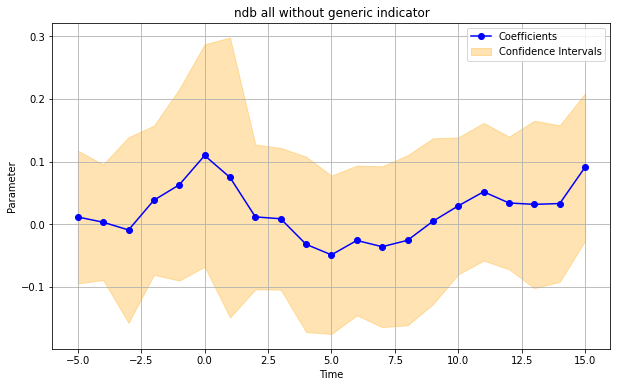

In [5]:
# all data
formula="log_quantity~ elasped_m5+elasped_m4+elasped_m3+elasped_m2+elasped_m1+elasped_0+elasped_1+elasped_2+elasped_3+elasped_4+elasped_5+elasped_6+elasped_7+elasped_8+elasped_9+elasped_10+TimeEffects+EntityEffects"

# till elasped_20
formula="log_quantity~ elasped_m5+elasped_m4+elasped_m3+elasped_m2+elasped_m1+elasped_0+elasped_1+elasped_2+elasped_3+elasped_4+elasped_5+elasped_6+elasped_7+elasped_8+elasped_9+elasped_10+elasped_11+elasped_12+elasped_13+elasped_14+elasped_15+TimeEffects+EntityEffects"


# add generic indicator
# formula+="+後発品区分"

# add generic per
# formula+="+generic_per"

formula+="+year_trend"

mod_fe=PanelOLS.from_formula(formula, data=df,check_rank=False,drop_absorbed=True)
res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)
# print(res_fe.summary.tables[1])
# print(res_fe.summary.tables[0])
print(res_fe)
# plot_result(res_fe,file_name="ndb_all",title="ndb_all",start_from=1,period=15)
plot_result(res_fe,file_name="ndb_all_without_generic",title="ndb all without generic indicator",start_from=1,period=20)